In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import glob
import os

from YOLO_API import YoloV3_API

D:\Anaconda\envs\rtav\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\rtav\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\rtav\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\rtav\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
img_dir = "../data/image/"
anno_dir = "../data/annotation/"

In [3]:
yoloAPI = YoloV3_API(
    img_dir=img_dir,
    annotation_dir=anno_dir,
    saved_model_name='final_yolo_model.h5',
    train_size=0.8,
    height=416,
    width=416,
    threshold=0.5,
    batch_size=2)

Image directory: ../data/image/
Annotation directory: ../data/annotation/
Saved model name: final_yolo_model.h5
Train/validation size ratio: 0.8
Training size: 416x416
Threshold: 0.5
Batch Size: 2

All Image and annotation size: 765
Unique labels: dict_keys(['car', 'bus'])
Generated Anchor Boxes: [8, 10, 14, 18, 24, 26, 35, 46, 41, 29, 48, 94, 64, 48, 85, 76, 92, 120]

Training image and annotation size: 612
Validation image and annotation size: 153
Maximum bounding boxes in all images: 15

Train Generator created: To access, use <YoloV3_API.train_generator>
Validation Generator created: To access, use <YoloV3_API.valid_generator>







Instructions for updating:
Use `tf.cast` instead.

YOLOv3 Training Model created: To access, use <YoloV3_API.train_model>

YOLOv3 Inference Model created: To access, use <YoloV3_API.infer_model>

Train Model Summary
__________________________________________________________________________________________________
Layer (type)                    Output 

In [4]:
%%time
history = yoloAPI.fit_generator(epoch=300, lr=1e-4)


Epoch 1/300
306/306 [==============================] - 252s 824ms/step - loss: 29.1363 - yolo_loss_layer_1_loss: 1.9723 - yolo_loss_layer_2_loss: 4.4807 - yolo_loss_layer_3_loss: 20.3542 - val_loss: 14.4493 - val_yolo_loss_layer_1_loss: 0.1791 - val_yolo_loss_layer_2_loss: 0.4617 - val_yolo_loss_layer_3_loss: 11.4791

Epoch 00001: loss improved from inf to 29.13630, saving model to final_yolo_model.h5
Epoch 2/300
306/306 [==============================] - 211s 689ms/step - loss: 7.6016 - yolo_loss_layer_1_loss: 0.1128 - yolo_loss_layer_2_loss: 0.4433 - yolo_loss_layer_3_loss: 4.7147 - val_loss: 5.9061 - val_yolo_loss_layer_1_loss: 0.0543 - val_yolo_loss_layer_2_loss: 0.2260 - val_yolo_loss_layer_3_loss: 3.2973

Epoch 00002: loss improved from 29.13630 to 7.60157, saving model to final_yolo_model.h5
Epoch 3/300
306/306 [==============================] - 218s 711ms/step - loss: 4.2626 - yolo_loss_layer_1_loss: 0.0339 - yolo_loss_layer_2_loss: 0.1661 - yolo_loss_layer_3_loss: 1.7379 - va

In [5]:
#### Proto
inf_model = yoloAPI.infer_model
inf_model.load_weights('final_yolo_model.h5')

In [24]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [30]:
### Read and resize image # Preprocess image


testimgpath = '..\data\Test_images'
file_types = ('\*.jpg', '\*.jpeg')
test_images = []
for files in file_types:
    test_images.extend(glob.glob(testimgpath+files))


    
img = cv2.imread(test_images[0])

mimg = preprocess_input(img, 416, 416)

# expected_height, expected_width, _ = img.shape
# net_h, net_w = 416,416
# if (float(416)/expected_width) < (float(net_h)/expected_height):
#     expected_height = (expected_height * net_w)//expected_width
#     expected_width = net_w
# else:
#     expected_width = (expected_width * net_h)//expected_height
#     expected_height = net_h

# print(str(expected_height) + ', ' + str(expected_width))

# img_resized = cv2.resize(img[:,:,::-1]/255, (expected_width, expected_height))

# print(img_resized.shape)
# new_img = np.ones((expected_height, expected_width, 3)) * 0.5
# new_img[(net_h-expected_height)//2:(net_h+expected_height)//2, (net_w-expected_width)//2:(net_w+expected_width)//2, :] = img_resized

# input_img = np.expand_dims(new_img, 0) # Shape is now (1, 416, 416, 3)
# input_img.shape
input_img.shape

(1, 416, 416, 3)

In [31]:
# Actual prediction
pred = inf_model.predict(input_img)
print(f'Big Pred: {pred[0].shape}')
print(f'Mid Pred: {pred[1].shape}')
print(f'Small Pred: {pred[2].shape}')

Big Pred: (1, 13, 13, 21)
Mid Pred: (1, 26, 26, 21)
Small Pred: (1, 52, 52, 21)


In [32]:
from scipy.special import expit #sigmoid
from imgaug import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

In [34]:
# Calculate Bounding Boxes for each predictions
all_boxes = []
for prediction in range(len(pred)):
    currPred = pred[prediction]
    anchors = yoloAPI.anchor_boxes[(2 - prediction) * 6 : (3 - prediction) * 6]
    
    grid_height, grid_width = currPred.shape[:2]
    pred_boxes = 3
    pred_out = currPred.reshape((grid_height, grid_width, pred_boxes, -1))
    num_cls = currPred.shape[-1] - 5
    
    boxes = []
    currPred[...,:2]=expit(currPred[...,:2])
    currPred[...,4]=expit(currPred[...,4])
    currPred[...,5:]=currPred[...,4][..., np.newaxis] * expit(currPred[...,5:])
    currPred[...,5:]=currPred[...,5:] > 0.5
    
    for idx in range(grid_height*grid_width): # Traverse entire grid
        r = idx//grid_width
        c = idx%grid_width
        for box_idx in range(pred_boxes):
            objectiveness_score=currPred[r, c, box_idx, 4] # Objectiveness score @ 5th index
            if (objectiveness_score <= 0.5):
                continue
            x, y, w, h = currPred[r, c, box_idx, :4]
            x = (c + x) / grid_width
            y = (r + y) / grid_height                                
            w = yoloAPI.anchor_boxes[2 * box_idx + 0] * np.exp(w) / expected_width
            h = yoloAPI.anchor_boxes[2 * box_idx + 1] * np.exp(h) / expected_height
            classes = currPred[r, c, box_idx, 5:]
            box = BoundingBox(
                x1=x-w/2,
                x2=y-h/2,
                y1=x+w/2,
                y2=y+h/2,
                label=classes)
            print(box)
            boxes.append(box)
    all_boxes += boxes
iabox = BoundingBoxesOnImage(all_boxes, shape=(416, 416))

BoundingBox(x1=0.0371, y1=0.0587, x2=0.6054, y2=0.6396, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0262, y1=0.0695, x2=0.5883, y2=0.6566, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0118, y1=0.0839, x2=0.5690, y2=0.6759, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1140, y1=0.1356, x2=0.6054, y2=0.6396, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1032, y1=0.1464, x2=0.5883, y2=0.6566, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.0887, y1=0.1609, x2=0.5690, y2=0.6759, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1909, y1=0.2125, x2=0.6054, y2=0.6396, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1801, y1=0.2234, x2=0.5883, y2=0.6566, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
BoundingBox(x1=0.1657, y1=0.2378, x2=0.5690, y2=0.6759, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [37]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].x1 = int((boxes[i].x1 - x_offset) / x_scale * image_w)
        boxes[i].x2 = int((boxes[i].x2 - x_offset) / x_scale * image_w)
        boxes[i].y1 = int((boxes[i].y1 - y_offset) / y_scale * image_h)
        boxes[i].y2 = int((boxes[i].y2 - y_offset) / y_scale * image_h)

In [39]:
correct_yolo_boxes(iabox.bounding_boxes, expected_height, expected_width, net_h, net_w)

In [40]:
iabox.bounding_boxes

[BoundingBox(x1=15.0000, y1=-66.0000, x2=251.0000, y2=175.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=10.0000, y1=-62.0000, x2=244.0000, y2=182.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=4.0000, y1=-56.0000, x2=236.0000, y2=190.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=47.0000, y1=-34.0000, x2=251.0000, y2=175.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=42.0000, y1=-30.0000, x2=244.0000, y2=182.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=36.0000, y1=-24.0000, x2=236.0000, y2=190.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=79.0000, y1=-2.0000, x2=251.0000, y2=175.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=74.0000, y1=1.0000, x2=244.0000, y2=182.0000, label=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 BoundingBox(x1=68.0000, y1=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


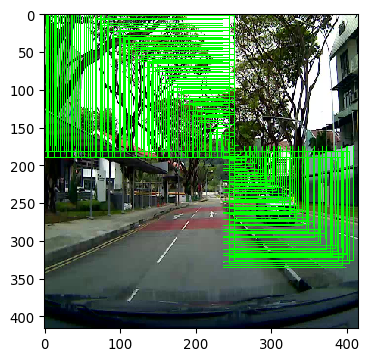

In [41]:
ia.imshow(iabox.draw_on_image(input_img[0]))

In [44]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].label)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.label[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].label[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].label[c] = 0

In [45]:
do_nms(iabox.bounding_boxes, 0.4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


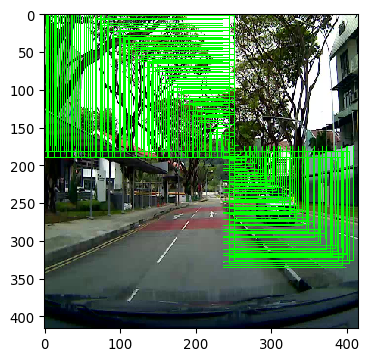

In [46]:
ia.imshow(iabox.draw_on_image(input_img[0]))